In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import gridspec
import scanpy as sc
from pathlib import Path
import scanpy as sc
import anndata
import muon 
import cnmf
import os

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
numiter=8 
numhvgenes=5451  
K = [30, 50] #, 60, 80, 100, 200, 250, 300] 
seed = 14
loss = 'frobenius'
init = 'random'
mode = "batch"
algo = 'bpp'
tol = 1e-5
batch_max_iter = 1000
online_max_pass = 200
online_chunk_size = 50000
online_chunk_max_iter = 1000
online_usage_tol = 0.05
online_spectra_tol = 0.05
use_gpu = True
batch_hals_max_iter = 1000
batch_hals_tol = 0.005


counts_fn = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Cell_data/100k_250genes.h5ad"
output_directory = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation"
run_name = "091425_100k_cells_10iter_torch_bpp_online_shuffled"


In [5]:

cnmf_obj = cnmf.cNMF(output_dir=output_directory, name=run_name)


In [6]:
cnmf_obj.prepare(counts_fn=counts_fn, components=K, n_iter=numiter, densify=False, tpm_fn=None, num_highvar_genes=numhvgenes, genes_file=None,
                init = init,  beta_loss = loss, 
                algo = algo,mode = mode, tol=tol, n_jobs=1, 
                seed=seed,  use_gpu = use_gpu, 
                alpha_usage=0.0, alpha_spectra=0.0, 
                l1_ratio_usage = 0.0, l1_ratio_spectra = 0.0,
                online_usage_tol=online_usage_tol, online_spectra_tol=online_spectra_tol,
                fp_precision = 'float', 
                batch_max_iter=batch_max_iter, batch_hals_tol = batch_hals_tol, batch_hals_max_iter = batch_hals_max_iter,
                online_max_pass=online_max_pass, online_chunk_size=online_chunk_size, online_chunk_max_iter=online_chunk_max_iter)


/oak/stanford/groups/engreitz/Users/ymo/Tools/torch_based_cNMF/src/cnmf/cnmf.py:1015: UserWarning: 16 runs already appear completed. If this is unexpected, consider
            re-initializing the cnmf object with a different run name or output directory
  warnings.warn(message, UserWarning)


In [6]:
cnmf_obj.factorize(total_workers = 1)

[Worker 0]. Starting task 0.
Use GPU mode.


/home/users/ymo/.local/lib/python3.9/site-packages/nmf/utils/_nnls_bpp.py:27: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1754.)
  n_iter = _nnls_bpp(CTC.cpu().numpy(), CTB.cpu().numpy(), X_cpu.numpy(), 'gpu')


In [7]:
cnmf_obj.combine()

Combining factorizations for k=30.
Combining factorizations for k=50.


CUDA is not available on your machine. Use CPU mode instead.


/oak/stanford/groups/engreitz/Users/ymo/Tools/torch_based_cNMF/src/cnmf/cnmf.py:492: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  WWj = (W_t @ W_t[j].T)  # shape (k,)


CUDA is not available on your machine. Use CPU mode instead.


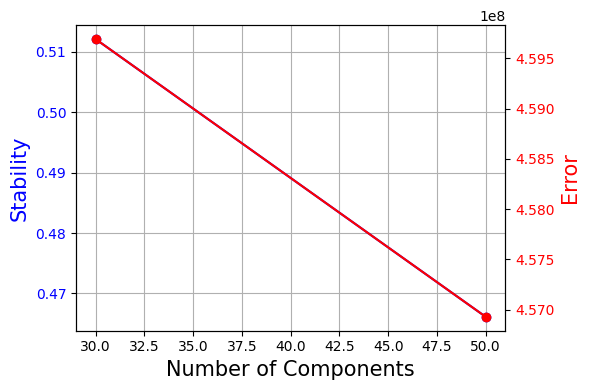

In [8]:
cnmf_obj.k_selection_plot()

In [9]:
from tqdm.auto import tqdm

def run_cnmf_consensus(cnmf_obj=None, output_dir=None, name=None, 
                       components=[7,8,9,10], density_thresholds=[0.01, 0.05, 2.0]):

    if cnmf_obj is None:
        cnmf_obj = init_cnmf_obj(output_dir=output_dir, name=name)

    for k in tqdm(components, desc='Running cNMF'):
        for thresh in density_thresholds:
            cnmf_obj.consensus(k=k, density_threshold=thresh, show_clustering=True)
    

Running cNMF:   0%|          | 0/2 [00:00<?, ?it/s]

CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.


/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CUDA is not available on your machine. Use CPU mode instead.


Running cNMF:  50%|█████     | 1/2 [00:58<00:58, 58.12s/it]

CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.


/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CUDA is not available on your machine. Use CPU mode instead.


Running cNMF: 100%|██████████| 2/2 [02:00<00:00, 60.50s/it]


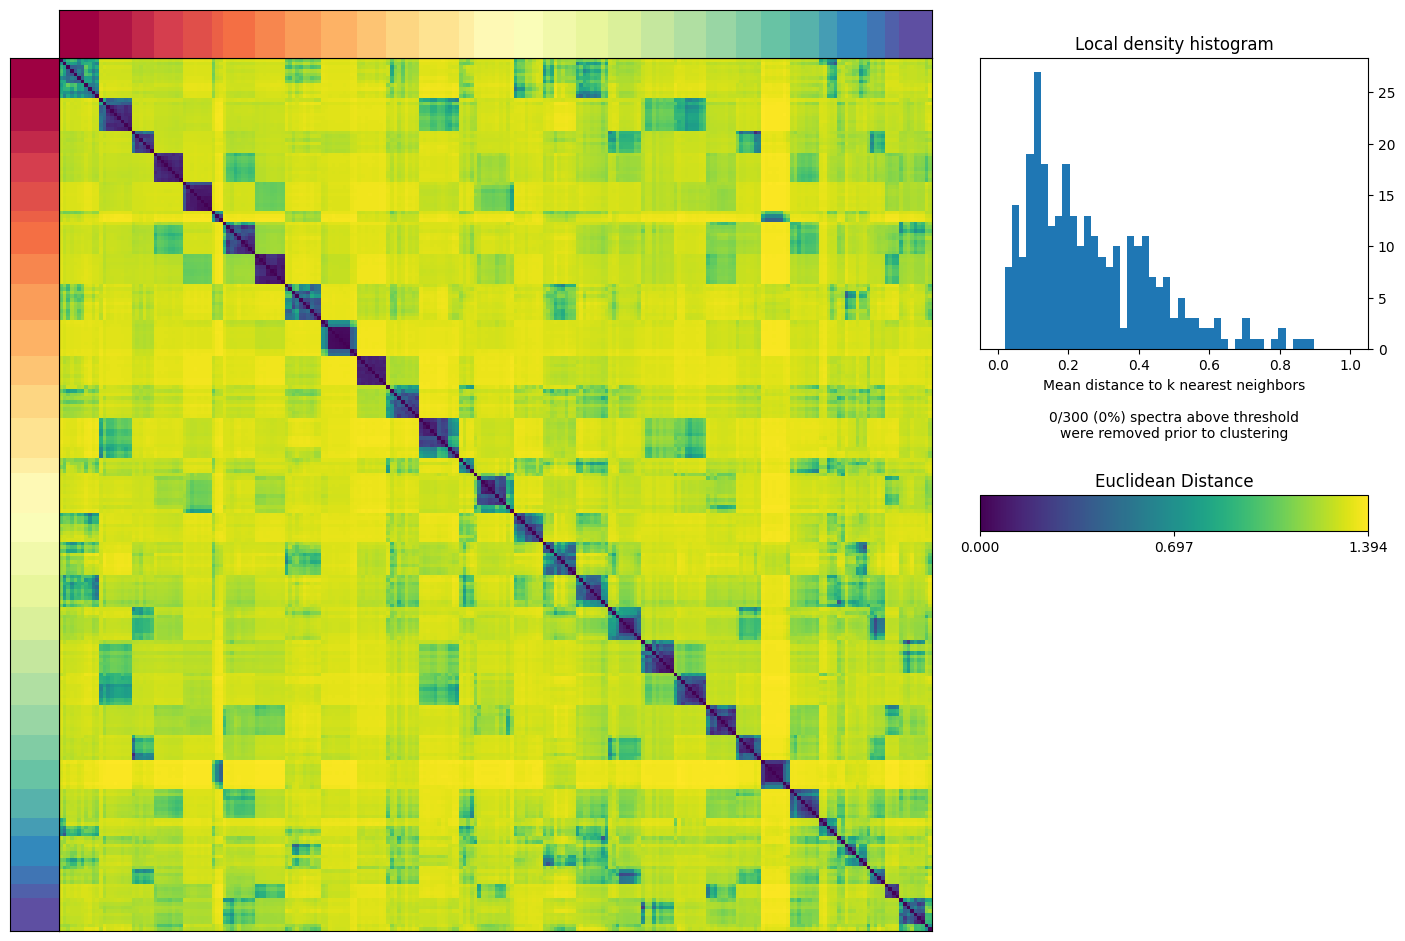

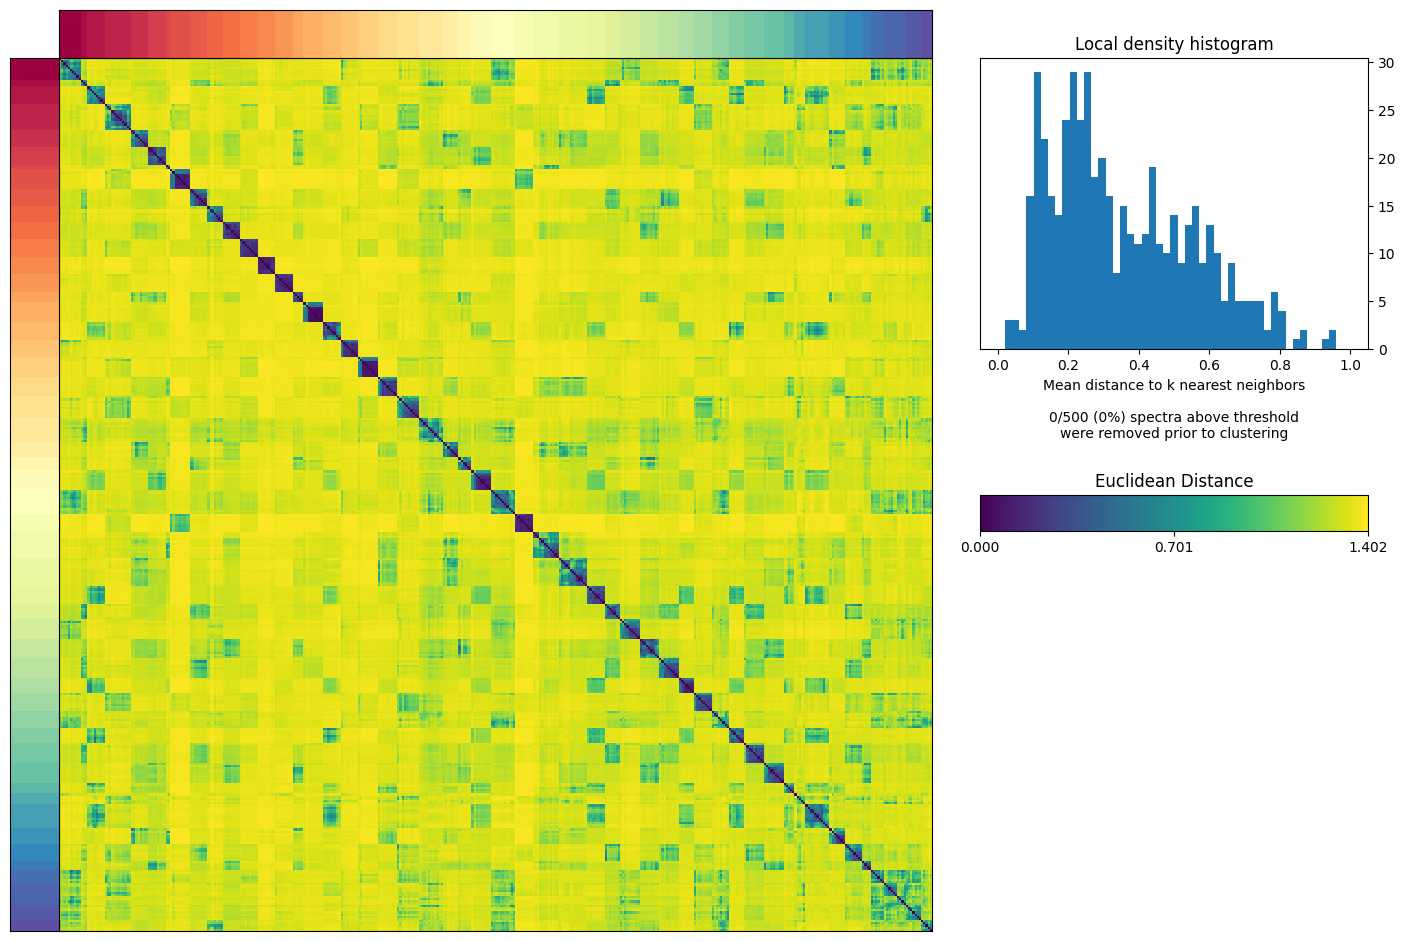

In [10]:
# Consensus plots with all k to choose thresh

sel_thresh = 2.0
run_cnmf_consensus(cnmf_obj, 
                components=K, 
                density_thresholds=[sel_thresh])

In [11]:
# Save all cNMF scores in separate mudata objects

for k in K:

    scores = pd.read_csv('{output_directory}/{run_name}/{run_name}.usages.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)

    loadings = pd.read_csv('{output_directory}/{run_name}/{run_name}.spectra.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)
    

    os.makedirs((f'{output_directory}/{run_name}/loading'), exist_ok=True)


    scores.to_csv('{output_directory}/{run_name}/loading/cNMF_scores_{k}_{sel_thresh}.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')
    loadings.T.to_csv('{output_directory}/{run_name}/loading/cNMF_loadings_{k}_{sel_thresh}.txt'.format(     
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')

    adata_ = anndata.read_h5ad('{output_directory}/{run_name}/cnmf_tmp/{run_name}.tpm.h5ad'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k ))
    adata_.var_names_make_unique()
    adata_.obs_names_make_unique()

    prog_data = anndata.AnnData(X=scores.values, obs=adata_.obs)
    prog_data.varm['loadings'] = loadings.values
    prog_data.uns['var_names'] = loadings.columns.values


    # Make adata
    os.makedirs((f'{output_directory}/{run_name}/prog_data'), exist_ok=True)
    prog_data.write(f'{output_directory}/{run_name}/prog_data/NMF_{k}_{sel_thresh}.h5ad'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))

    # Make mdata
    mdata = muon.MuData({'rna': adata_, 'cNMF': prog_data})

    os.makedirs((f'{output_directory}/{run_name}/adata'), exist_ok=True)
    mdata.write(f'{output_directory}/{run_name}/adata/cNMF_{k}_{sel_thresh}.h5mu'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))
                                                                            